# Covid long et offre de travail

Projet réalisé en 2025 par Lucile Aubain, Jean Lavallée et Paul Hobeika dans le cadre du cours de *Python pour la data science* enseigné en deuxième année de l'ENSAE.

<a id="introduction"></a>
# Introduction

La pandémie de Covid-19 a contaminé 800 millions de personnes et entraîné le décès de sept millions de personnes dans le monde entre 2020 et 2025, dont 150 000 en France. Ces conséquences directes du Covid-19 s'accompagnent d'effets de plus long terme sur le marché du travail. Dans ce projet, nous nous intéressons dans ce cadre à une réalité qui est rarement analysée en France sous l'angle de la santé publique : l'augmentation des arrêts de travail pour maladie depuis 2020.

Une littérature en médecine montre que de nombreuses personnes ayant contracté le Covid-19 et survécu développent des problèmes de santé persistants. Ces séquelles de long terme recouvrent des symptômes aussi divers que la fatigue chronique, des troubles neurologiques ou des difficultés respiratoires, qui peuvent limiter la capacité des personnes touchées à accomplir leurs activités quotidiennes, y compris leur activité professionnelle ([Ford et al., 2025](https://onlinelibrary.wiley.com/doi/abs/10.1002/ajim.70014?casa_token=NAKQSBiFLa8AAAAA%3AIUjd4EXrl4jU1-7FkTjwP6W7jjW2aly-mTo0LDxL27Oh4bVbCj11uAcFBwdYeCaNNGGWgzkhD-0v5TfP), [MacEwan et al., 2025](https://link.springer.com/article/10.1007/s11606-024-09062-5)). Ces affections sont couramment qualifiées de « Covid long » ([Groff et al., 2021](https://pubmed.ncbi.nlm.nih.gov/34643720/)).

Plusieurs acteurs publics ainsi que des médias ont avancé l’idée que ces affections de long terme auraient réduit l’offre de travail. Un rapport de la *Brookings Institution* ([2022](https://www.brookings.edu/articles/is-long-covid-worsening-the-labor-shortage/)) estime que le Covid long pourrait éloigner jusqu'à 4 millions d'Américains de l'emploi, et ainsi représenter jusqu'à 15 % des postes vacants aux Etats-Unis en 2022. Dans l'Union européenne, un rapport de la Commission européenne ([2024](https://economy-finance.ec.europa.eu/document/download/36713cbb-6cbf-4ddb-8a15-55a4f456e2cb_en?filename=eb077_en.pdf)) estime que le Covid long dans l'UE se traduit par un impact négatif sur l'offre de main-d'œuvre de 0,2 à 0,3 % en 2021 et de 0,3 à 0,5 % en 2022, soit entre 600 000 et 1 million de personnes en 2022. Ces ordres de grandeur sont similaires à ceux estimés par Abraham et Rendell ([2023](https://www.brookings.edu/wp-content/uploads/2023/03/BPEA_Spring2023_Abraham-Rendell_unembargoed.pdf)) pour les Etats-Unis, et par Espinosa Gonzalez et Suzuki ([2024](https://www.oecd.org/content/dam/oecd/en/publications/reports/2024/06/the-impacts-of-long-covid-across-oecd-countries_f662b21c/8bd08383-en.pdf)) pour l'ensemble des pays de l'OCDE. Ce canal par lequel le Covid-19 aurait affecté l'économie pourrait ainsi amener à revoir largement à la hausse son coût économique estimé, jusqu'à 1000 milliards de dollars pour l'OCDE ([Espinoza Gonzalez et Suzuki, 2024](https://www.oecd.org/content/dam/oecd/en/publications/reports/2024/06/the-impacts-of-long-covid-across-oecd-countries_f662b21c/8bd08383-en.pdf)).

Ce travail propose d'étudier l'effet de l'exposition au Covid-19 en 2020 sur l'offre de travail de long terme des salariés dans le contexte français, à partir des données de l'Enquête emploi en continu (EEC). Nous proposons d'abord une méthode pour classer les secteurs d'activités selon leur exposition à la pandémie de Covid-19. Puisque l'Enquête emploi ne présent pas de variable permettant de caractériser directement la plus ou moins grande exposition au Covid-19 en 2020, nous proposons une méthode indirecte pour estimer un degré d'exposition selon la catégorie socioprofessionnelle et le secteur d'activité. Nous faisons l'hypothèse que le taux de salariés en arrêt de travail pour maladie en 2020, pour une certaine catégorie d'actifs, est un bon *proxy* de l'exposition au virus lors de l'année 2020. Le contexte de crise sanitaire et l'arrêt de la production de certains secteurs économiques, conjuguée aux mesures de confinement, ont en effet conduit à surexposer certaines professions et secteurs économiques tout en en protégeant certains autres ([Dubost, Pollak et Rey, 2020](https://drees.solidarites-sante.gouv.fr/sites/default/files/2020-10/DD62.pdf)).

Nous montrons ensuite que les salariés des secteurs exposés réduisent leur offre de travail de façon persistante, bien après le pic de la pandémie. Une analyse d’événement indique que les travailleurs des secteurs les plus exposés au Covid-19 en 2020 ont une probabilité inférieure d’environ X points de pourcentage d’être en activité un an plus tard, relativement à des travailleurs similaires des secteurs non exposés. A plus long terme, en 2024, DÉVELOPPER.

Ce travail s'inscrit en premier lieu dans la littérature qui étudie les liens entre Covid long et sortie de la population active ([Evans et al., 2021](https://www.sciencedirect.com/science/refhub/S0047-2727(23)00071-3/h0095), [Ziauddeen et al. (2022)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264331), [Evans et al. (2021)](https://www.sciencedirect.com/science/refhub/S0047-2727(23)00071-3/h0095)). En particulier, Goda et al., ([2023](https://www.sciencedirect.com/science/article/pii/S0047272723000713)) montrent sur des données américaines que les travailleurs ayant été absents une semaine en raison du Covid-19 en 2020 ont 7 % moins de chance d'être toujours actifs un an plus tard que les travailleurs similaires qui n'ont pas manqué le travail pour raisons de santé en 2020. Cet effet de long terme de la pandémie de Covid-19 expliquerait un manque de 500 000 emplois aux Etats-Unis. A partir de données néerlandaises, Bussink et al. ([2025]()) montrent qu’une infection au Covid-19 réduit la probabilité d’emploi des nouveaux entrants sur le marché du travail de environ 1 point de pourcentage dans les trois mois qui suivent leur diplomation. L'effet plus limité du Covid long sur l'offre de travail obtenu par cette seconde étude peut s'expliquer par la plus faible exposition des jeunes adultes au Covid long par rapport à la moyenne des adultes étudiés dans l'étude de Goda et al. (2023).

Ce travail s'inscrit également dans les débats de politique économique relatifs aux travailleurs « manquants » (*missing workers*) observés dans la population active après la pandémie. Reuschke et Houston ([2022](https://www.tandfonline.com/doi/full/10.1080/13504851.2022.2098239)) montrent 80 000 personnes ont quitté leur emploi en raison du COVID long au Royaume-Uni, exacerbant ainsi la pénurie de main-d'œuvre dans le pays. Nos résultats font ainsi écho aux difficultés de recrutement rencontrées par les entreprises de certains secteurs en France entre 2021 et 2023.

COMMENTAIRE DE PAUL : je dirais que ces deux derniers paragraphes seraient à remonter un peu plus haut, avec la revue de littérature qui précède. 

Notre travail est par la suite organisé de la façon suivante. Dans la section [Installation](#installation), nous téléchargeons et installons les libraires nécessaires au bon déroulé du code ultérieur. Cette partie appelle également les fonctions utilisées par la suite. Dans la section [Données](#donnees), nous importons et nettoyons nos données avant de proposer une classification des secteurs selon leur exposition au Covid-19 dans la section [Statistiques descriptives](#descriptives). Nous analysons enfin l'effet du Covid sur l'offre de travail par secteur sur le long terme dans la section [Covid long et réduction de l'offre de travail](#modelisation), avant de conclure dans la section [Conclusion](#conclusion).


<a id="sommaire"></a>
## Sommaire
- [Introduction](#introduction)
- [Installation](#installation)
- [Données](#donnees)
- [Statistiques descriptives](#descriptives)
- [Covid long et réduction de l'offre de travail](#modelisation)
- [Conclusion](#conclusion)
- [Bibliographie complémentaire](#bibliographie)

<a id="installation"></a>
## Installation

In [2]:
%%capture
%pip install -r scripts/requirements.txt

# Modules
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import requests
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from lets_plot import *
from palmerpenguins import load_penguins #  supprimer ? Je pense pas qu'on l'utilise
from urllib import request
from io import BytesIO
from sklearn.cluster import KMeans # on n'utilise pas non a priori ?
import linearmodels as lm
from linearmodels.panel import PanelOLS
import seaborn as sns
import importlib
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy.contrasts import Treatment


# Fonctions
from scripts import import_eec
from scripts import import_eec_all
from scripts import hospitalisations
from scripts import exposition

<a id="donnees"></a>
## Import des données

Dans le cadre de ce travail, nous analysons les données relatives aux absences issues des fichiers détails de l'Enquête emploi en continu (EEC). Un travailleur est enregistré comme absent s'il déclare à la fois être en activité et n'avoir effectué aucune heure de travail durant la semaine de référence de l'EEC. De plus, la « raison principale » de leur absence est demandée à tous les travailleurs absents (variable `RABS`). Parmi les dix motifs pouvant être invoqués par les employés figure « Congé maladie (y compris arrêt après un accident au travail) » (`RABS = 2`).

Cette variable est présente dans les fichiers détails de l'Enquête Emploi, accessibles en *open data* sur directement depuis le site de l'Insee (mais pas depuis la librairie python `pynsee`). Les fichiers étant publiés chaque année, l'import des données implique d'importer séparément chacune des années d'intérêt, puis d'assembler les différentes tables. Nous avons choisi d'utiliser les tables depuis 2010 jusqu'en 2024. L'une des difficultés est que les variables peuvent varier selon les années : certaines variables peuvent changer de nom, de nomenclature voire disparaître d'une année sur l'autre. Par exemple, la variable d'âge est en 5 modalités et s'appelle `AGE5` en 2018 et 2019 puis elle passe à 6 modalités avec un découpage différent à partir de 2020 et s'appelle alors `AGE6`, ce qui la rend inutilisable dans notre cas. 

La plupart des variables qui nous intéressent restent cependant inchangées entre 2010 et 2024, en particulier : 

- la variable indiquant le statut d'activité des enquêtés (`ACTEU`), permettant de distinguer les actifs en emploi (`ACTEU = '1'`) du reste de la population.
- la variable permettant d'identifier les actifs déclarant n'avoir pas travaillé durant la semaine de référence pour cause de maladie (`RABS = '2'`).
- l'année de l'enquête (`ANNEE`).

D'autre variables dont nous avons besoin changent de nom (mais pas de nomenclature) selon les années. Lors de l'importation des données, nous renommons donc les variables suivantes afin de pouvoir les conserver dans la table résultant de la concaténation de toutes les fichiers détail de 2010 à 2024 : 

- la variable de catégorie socioprofessionnelle à 2 chiffres : présente sous des noms différents, nous la renommons `CSE` pour l'ensemble des années
- la variable de secteur d'activité à 38 modalités : `NAFG38UN`

La fonction `load_eec_all()` importe les différentes bases de données annuelles puis les assemble en une base de données multiannuelle en conservant toutes les variables présentes avec le même nom toutes les années. Pour éviter d'avoir à faire systématiquement cette phase d'importation qui est longue (en particulier pour les fichier `.dbf` utilisés de 2010 à 2017), nous avons enregistré la base obtenue (avec les 22 variables) dans un fichier `PARQUET` que l'on peut importer directement.

In [3]:
# Import des données #
######################
 
# Méthode 1 (lente, prend environ 5 minutes) : téléchargement direct depuis le 
# site de l'Insee ou via les url backup en cas d'erreur
#
# eec_all = import_eec_all.load_eec_all()
#
# Sauvegarde locale pour usage ultérieur
#
# object_cols = eec_all.select_dtypes(include='object').columns
# eec_all[object_cols] = eec_all[object_cols].astype(str)
# eec_all.to_parquet('data/eec_all.parquet', index=False)



# Méthode 2 (rapide) : chargement depuis un fichier obtenu via la méthode 1
# sauvegardé sur l'espace de stockage du SSP Cloud

eec_all = pd.read_parquet("https://minio.lab.sspcloud.fr/phobeika/open_eec/eec_all.parquet")

Selon les années, les données importées n'ont pas exactement le même format. Pour éviter les erreurs liées à des petites différences entre les années (par exemple des modalités `1` et `1.0` pour des variables catégorielles qui ont été à un moment enregistrées comme valeurs numériques), on utilise la fonction `recodages()` qui permet d'éviter ces problèmes en plus que de distinguer les variables selon leur type (catégoriel ou numérique).

In [ ]:
# Recodages
eec_all = import_eec.recodages(
    eec_all, 
    vars_cat=['RABS', 'ACTEU', 'SEXE', 'CSE', 'PUB3FP'], 
    vars_num=['ANNEE']
    )

Enfin, on peut filter l'ensemble des données de manière à ne travailler que sur la population active.

In [ ]:
# Filter pour ne conserver que les actifs
eec_actifs = eec_all[eec_all['ACTEU'] == "1"].copy()

In [ ]:
eec_actifs = import_eec.add_labels(eec_actifs)

In [ ]:
# vérifications - à supprimer ? - oui supprimez quand vous voulez

#sorted(eec_actifs["ANNEE"].dropna().unique().astype(int).tolist())
#eec_actifs[["CSE", "CSE_label"]].value_counts(dropna=False)
#eec_actifs[["SEXE", "SEXE_label"]].value_counts(dropna=False)
#eec_actifs[["CSER", "CSER_label"]].value_counts(dropna=False)
eec_actifs[["PUB3FP", "PUB_label"]].value_counts(dropna=False)

PUB3FP  PUB_label            
4       Secteur privé            1852820
<NA>    NaN                       347422
1       État                      254272
2       Collectivités locales     222379
3       Hôpitaux publics          117998
Name: count, dtype: int64

# Statistiques descriptives - CHANGER TITRE ET DESCRIPTION

Nous examinons à présent si, durant la pandémie, les taux d’absence pour raisons de santé ont davantage augmenté parmi les travailleurs dont les professions les exposent à un risque accru de contracter le Covid-19.

## Les absences pour congé maladie comme proxy de la contamination par le Covid-19

Comment pallier l'absence de données sur les contaminations au Covid-19 en 2020 ? Pour déterminer les secteurs d'activité qui ont été les plus touchés sans disposer de données ouvertes permettant de croiser exposition au Covid-19 et secteur d'activité, nous proposons d'utiliser les absences pour congé maladie en 2020 comme proxy de l'exposition au virus lors de cette année. 

Nous faisons l'hypothèse que, dans le contexte pandémique de l'année 2020, les absence au travail pour maladie sont fortement corrélées à la circulation du Covid-19. Pour appuyer cette hypothèse, nous étudions dans cette section la corrélation entre l'intensité pandémique mesurée à partir du nombre d'hospitalisations pour Covid-19 et les arrêts de travail pour maladie.

Après avoir récupéré les données des hospitalisations liées au Covid-19 en 2020 via une API de Santé publique France, nous comparerons l'évolution en base 100 du nombre d'hospitalisations et d'arrêts maladies. Les données de l'enquête emploi en continu étant uniquement détaillées par trimestre, il s'agira d'étudier la corrélation entre ces deux variables à l'échelle trimestrielle. 

ou 

Les taux d’absence pour raisons de santé suivent globalement la hausse et à la baisse des taux d'hospitalisation liés au Covid-19 dans les séries temporelles sur l'année 2020. La Figure 2 présente le nombre total d'arrêt de travail pour cause de maladie et le nombre total d'hospitalisations liées au Covid-19 en France pour chaque trimestre entre janvier 2020 et décembre 2020. La corrélation de ces deux variables est environ de 0.7, laissant penser que la catégorie "arrêts de travail pour cause de maladie" constitue un bon proxy de contamination par le Covid-19 en 2020.


### L'évolution du nombre d'hospitalisations liées au Covid en 2020

Tout d'abord, pour récupérer les données concernant le nombre d'hospitalisations liées au Covid-19, nous avons utilisé l'API Huwise de Santé publique France, présente sur le portail open data Odissé :  
https://odisse.santepubliquefrance.fr/explore/dataset/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/api/?sort=date

Après quelques heures d'errance sur la documentation de l'API (https://help.opendatasoft.com/apis/ods-explore-v2/) et des requêtes fortement limitées dans leur nombre de résultats, nous avons exporté l'ensemble de la base "Covid-19 - Sythèse des indicateurs de suivi de la pandémie", via les commandes indiquées dans la documentation. 

In [6]:
hosp = hospitalisations.import_hosp()
eec20 = eec_actifs[eec_actifs['ANNEE'] == 2020]

Tentative de téléchargement depuis: https://odisse.santepubliquefrance.fr/api/explore/v2.1/catalog/datasets/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/exports/json
Importation réussie.


Pour pouvoir grouper et sommer les observations par date, nous avons sélectionné les données de 2020 en s'assurant qu'il existe toujours le même nombre de départements observés pour chaque date (101). Nous avons ensuite représenté graphiquement le nombre d'hospitalisations en fonction du temps, avec des étiquettes mensuelles pour plus de lisibilité


In [7]:
hospitalisations.plot_hosp_year(hosp, year = 2020)

# Agrandir le graphique svp

On retrouve bien les deux "vagues" caractéristiques du Covid en France en 2020.

### La corrélation entre hospitalisations liées au Covid-19 et absences du travail pour congé maladie

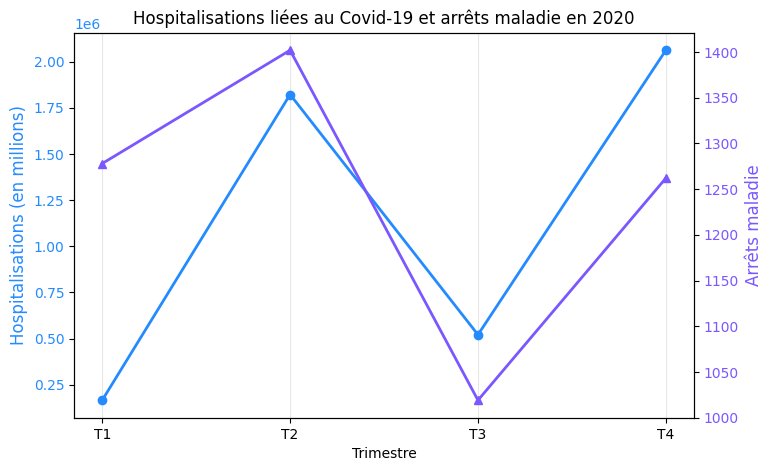

Coefficient de corrélation entre les deux variables : 0.51


In [8]:
hospitalisations.plot_hosp_arrets_trim(eec20, hosp)

La corrélation entre le nombre d'arrêts de travail pour congé maladie et le nombre d'hospitalisations liées au Covid est de 0.51, ce qui est convenable pour un *proxy*, d'autant plus qu'une partie des personnes qui se seraient peut-être mis en arrêt de travail étaient déja arrêtées (chômage partiel...), réduisant les variations du nombre d'arrêts de travail.

## Statistiques descriptives sur ce proxy

Une deuxième façon de vérifier la pertinence de notre proxy est de comparer l'évolution du nombre d'arrêts de travail pour congé maladie en 2020 aux autres années. En lien avec notre problématique, on peut directement représenter cette évolution en fonction de nos variables d'intérêt, par exemple le sexe et la PCS. 

### Des inégalités structurelles dans la probabilité d'être en arrêt maladie, accentuées par le Covid-19

#### Le genre comme facteur d'exposition différenciée 

In [9]:
# Calcul de la proportion d'hommes et de femmes en arrêt de travail selon les années 
df_sexe_annee = exposition.exposition_annee(eec_actifs, var="SEXE_label", year_col="ANNEE")
# df_sexe_annee.head(25)

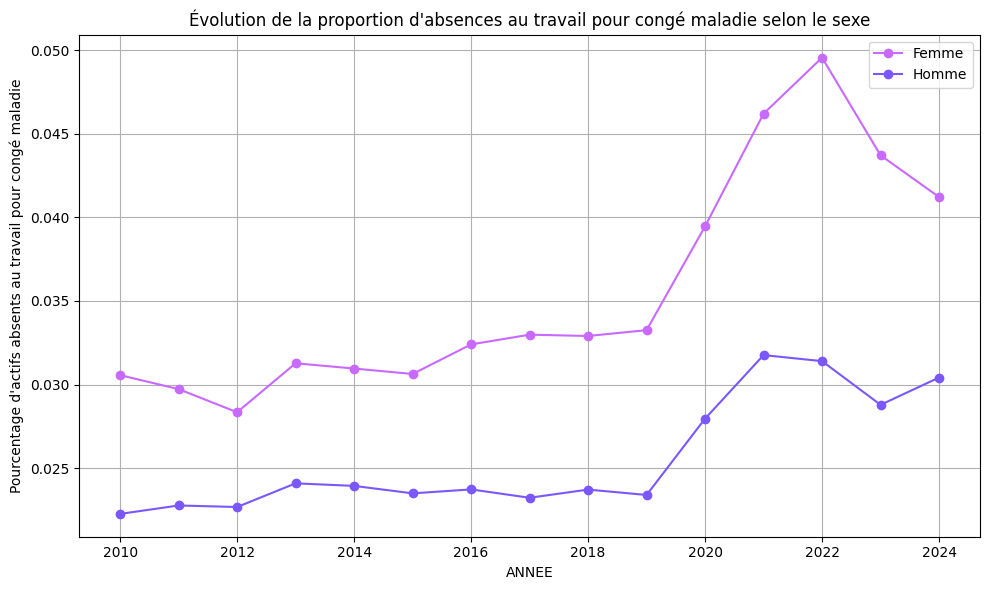

In [10]:
#### L'évolution du nombre d'arrêts de travail pour congé maladie en fonction du sexe

exposition.plot_evolution_proportion(
    df=df_sexe_annee,
    year_col="ANNEE",
    group_col="SEXE_label",
    value_col="proportion_rabs2",
    title="Évolution de la proportion d'absences au travail pour congé maladie selon le sexe",
    ylabel="Pourcentage d'actifs absents au travail pour congé maladie",
    colors= {"Homme": "#7A57FF","Femme": "#C869FF"}
)

#### La position socio-professionnelle comme facteur d'exposition différenciée 

In [11]:
# Calcul de la proportion d'actifs en arrêt de travail selon les années en fonction de la PCS
df_pcs_annee = exposition.exposition_annee(eec_actifs, var="CSER_label", year_col="ANNEE")
#df_pcs_annee.head(25)

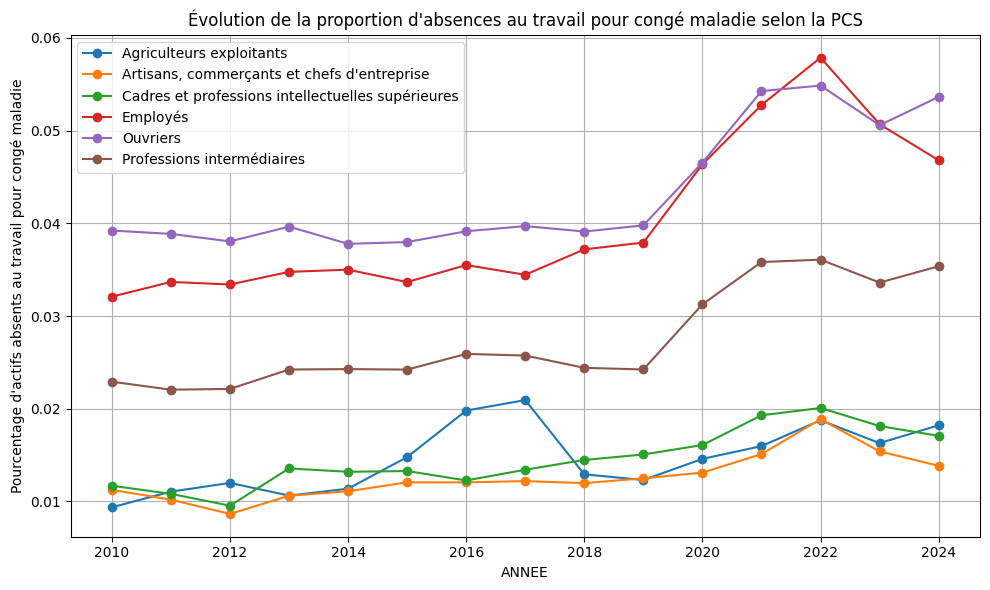

In [12]:

##### L'évolution du nombre d'arrêts de travail pour congé maladie en fonction de la PCS

exposition.plot_evolution_proportion(
    df=df_pcs_annee,
    year_col="ANNEE",
    group_col="CSER_label",
    value_col="proportion_rabs2",
    title="Évolution de la proportion d'absences au travail pour congé maladie selon la PCS",
    ylabel="Pourcentage d'actifs absents au travail pour congé maladie",
    )
# revoir couleurs ?

## Construction d'une mesure d'exposition au Covid-19 par secteur d'activité

Mettre ici le code pour le random forest

La Figure ci-dessous présente la relation entre les absences pour raisons de santé et le niveau d'exposition au Covid-19 par secteur.

Les résultats obtenus sont cohérents avec ceux de Mongey et al. ([2023](https://link.springer.com/article/10.1007/s10888-021-09487-6)), qui mobilisent les données O\*NET américaines pour classer les professions selon leur aptitude au télétravail et selon le degré de proximité physique avec d’autres personnes requis par les tâches habituelles.

In [13]:
# Fonction pour calculer la proportion d'actifs en arrêts de travail durant la semaine de référence selon les catégories d'une variable donnée (ici 'CSE')
exposition.exposition(eec20, var = 'CSE', year = 2020).head()

,label,CSE,effectif_total,effectif_rabs2,proportion_rabs2
20,Employés civils & agents de service FP,52,13377,814.0,6.09
27,Chauffeurs,64,3598,197.0,5.48
25,Ouvriers qualifiés type industriel,62,5483,271.0,4.94
28,Ouvriers manutention / magasinage / transport,65,2472,116.0,4.69
30,Ouvriers non qualifiés type artisanal,68,3851,178.0,4.62


### Contrôle par le nombre d'arrêt de travail précédant le Covid

Attention cependant, il serait erroné de considérer la seule proportion d'arrêts maladie en 2020 comme proxy de la contamination au Covid-19. En effet, comme le montre la Figure [insérer nom Figure PCS / arrêts maladie toute la période], il y a des différences structurelles entre secteurs d'activité dans la proportion d'actifs en arrêt maladie. Du fait de leurs conditions de travail [insérer référence ?] (pénibilité, risques d'accident...), les ouvriers et les employés sont par exemple systématiquement plus en arrêt maladie que les autres. C'est donc également le cas en 2020, sans que cela reflète une plus forte exposition au Covid. Nous nous intéresserons donc plutôt à la différence, pour chaque secteur, entre la proportion d'actifs en arrêt maladie en 2020 et celle en 2019, une différence positive reflétant donc une augmentation des arrêts maladies, que nous attribuons en partie au Covid.

In [14]:
# Fonction pour calculer la différence de proportion d'actifs en arrêts de travail durant la semaine de référence entre deux années selon les catégories d'une variable donnée (ici 'CSE')
exposition.exposition_diff(eec_actifs, year1 = 2019, year2 = 2020, var = 'CSE')
# exposition.exposition_diff(eec_actifs, year1 = 2019, year2 = 2020, var = 'NAFG038UN')

,label,CSE,prop_2019,prop_2020,difference
27,Chauffeurs,64,4.07,5.48,1.41
0,Non renseigné,0,1.28,2.68,1.40
14,Professions santé & travail social,43,2.95,4.35,1.40
20,Employés civils & agents de service FP,52,4.90,6.09,1.19
19,"Contremaîtres, agents de maîtrise",48,2.94,4.11,1.17
29,Ouvriers non qualifiés type industriel,67,3.59,4.62,1.03
6,Chefs d'entreprise (10 salariés ou plus),23,0.31,1.34,1.03
22,Employés administratifs d'entreprise,54,2.77,3.80,1.03
16,Intermédiaires admin. fonction publique,45,2.36,3.23,0.87
21,Policiers & militaires,53,3.46,4.20,0.74


### Cohérence avec la littérature

[insérer catégories exposées dans d'autres enquêtes, la similarité avec celles qu'on a et des pistes d'explication]

### Calcul du score d'exposition 

[Justifier la combinaison des PCS détaillées et des secteurs d'activité NAF]
[Expliquer qu'ils se recoupent en partie mais pas totalement ; on enlèvera plus tard les catégories regroupant mécaniquement trop peu de gens]
[Expliquer et justifier notre score d'exposition comme sommme des deux scores d'exposition]

[Repartir de notre cadre = absence de données individuelles : nos individus c'est les secteurs]

In [15]:
# Ajout de la variable de score d'exposition à la table eec_actifs
eec_actifs = exposition.score_exposition(eec_actifs, var_list = ['CSE', 'NAFG038UN'])
eec20 = eec_actifs[eec_actifs['ANNEE'] == 2020]

In [16]:
eec_actifs.head()

,AAC,ACTEU,ANCCHOM,ANNEE,CHPUB,CSE,DISPPLC,EXTRIAN,NAFG038UN,OFFICC,...,TRIM,SEXE_label,PUB_label,CSE_label,CSER,CSER_label,NAF_label,score_CSE,score_NAFG038UN,score_exposition
3,,1,,2010,2,52,,154.013793,OZ,3,...,1,Homme,Collectivités locales,Employés civils & agents de service FP,5.0,Employés,Administration publique,2.0,2.0,4.0
4,,1,,2010,2,52,,148.713215,OZ,3,...,2,Homme,Collectivités locales,Employés civils & agents de service FP,5.0,Employés,Administration publique,2.0,2.0,4.0
5,,1,,2010,2,52,,160.098185,OZ,3,...,3,Homme,Collectivités locales,Employés civils & agents de service FP,5.0,Employés,Administration publique,2.0,2.0,4.0
6,,1,,2010,2,52,,150.064252,OZ,3,...,4,Homme,Collectivités locales,Employés civils & agents de service FP,5.0,Employés,Administration publique,2.0,2.0,4.0
8,1,1,,2010,3,52,,157.836818,QA,1,...,3,Homme,Hôpitaux publics,Employés civils & agents de service FP,5.0,Employés,Activités pour la santé humaine,2.0,2.0,4.0


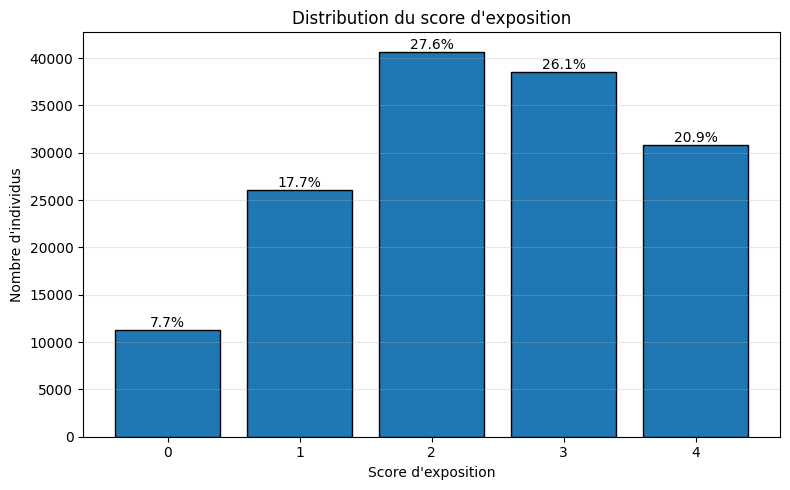

In [17]:
exposition.plot_score_exposition(eec20)
# pondérer ce code ?

In [18]:

importlib.reload(exposition)

<module 'scripts.exposition' from '/home/onyxia/work/projet_python/scripts/exposition.py'>

## Un risque d'exposition socialement différencié ?

### Le lien entre l'exposition au Covid du secteur d'activité et le sexe, la PCS et le caractère public de l'emploi

#### Statistiques descriptives

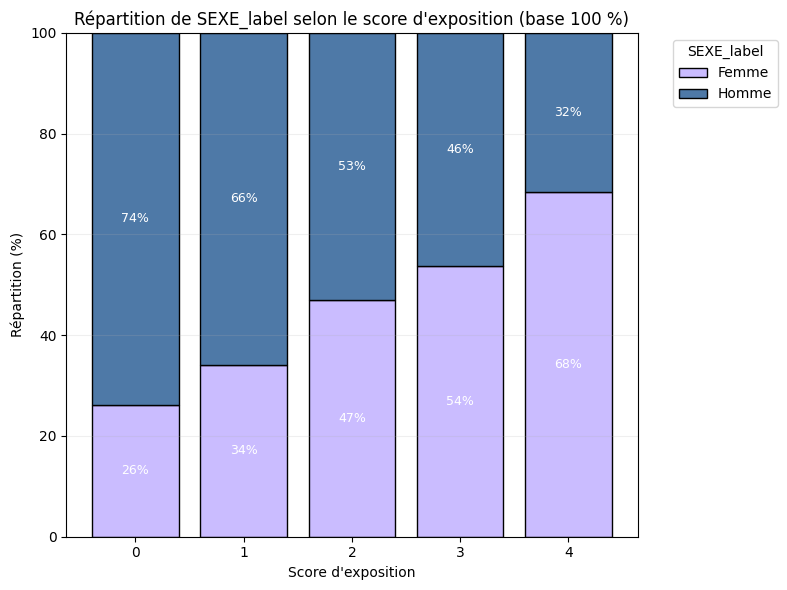

In [19]:
exposition.plot_freq_exposition(eec20, by='SEXE_label',figsize=(8,6))

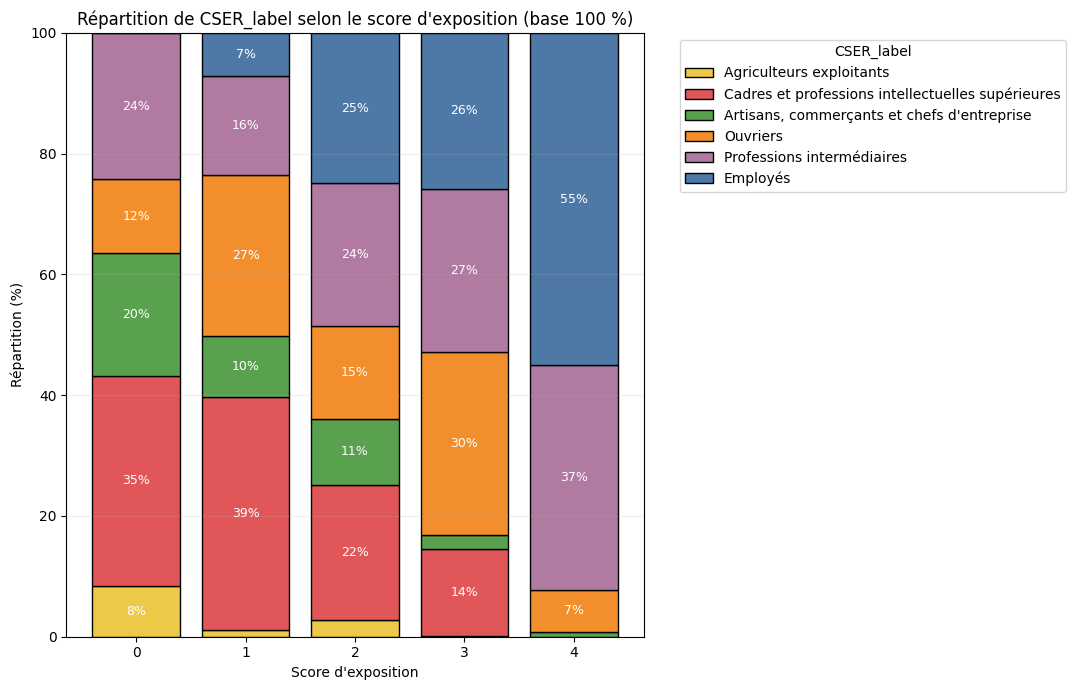

In [20]:
exposition.plot_freq_exposition(eec20, by='CSER_label',  figsize=(11,7))
# là j'ai repris un code couleur utilisé par l'Insee pour les PCS mais c'est pas dans le style de notre chartre couleur pastel

[Discuter de l'importance des différences présentes dans les résultats, en lien avec la manière dont a été calculée le score d'exposition : car puisqu'il a été construit uniquement sur la base des secteurs les plus exposés, il y a déja un regroupement via le secteur d'activité, qui explique peut être pk y a aucun cadre dans les secteurs les plus exposés (choisis par tertiles), même s'il doit y avoir un certain % de cadres parmi les plus exposés] => en gros la manière précédente de constuire le score accentue peut être les différences selon une variable liée au secteur d'activité (ici la PCS) 

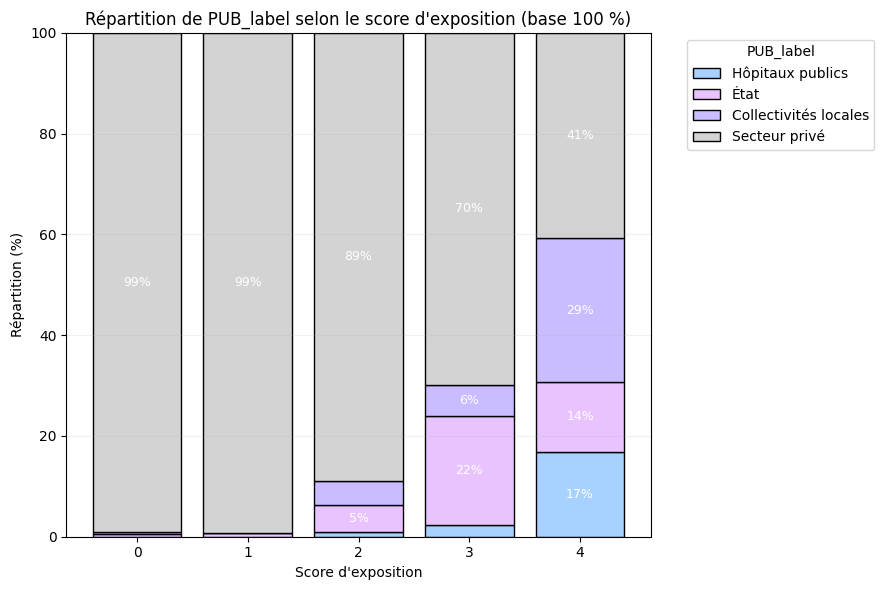

In [21]:
exposition.plot_freq_exposition(eec20, by='PUB_label')
# Exclues du graphique personnes non actives occupées et actifs occupés indépendants STAT2 distinct de 2

#### Modèles de régression linéaire

Comment ces trois variables explicatives (le sexe, la PCS, et le caractère public ou non de l'emploi) interagissent-elles pour prédire le score d'exposition au Covid, associé aux combinaisons de secteurs d'activité ? 

In [42]:
importlib.reload(exposition)

<module 'scripts.exposition' from '/home/onyxia/work/projet_python/scripts/exposition.py'>

In [ ]:
# On vérifie que les variables qu'on souhaite utiliser comme régresseurs soient bien catégorielles
categorical_vars = ["SEXE_label", "CSER_label", "PUB_label"]
reference_dict = {"SEXE_label": "Homme", "CSER_label": "Cadres et professions intellectuelles supérieures", "PUB_label": "Secteur privé"}

df_coef, modele_robust = exposition.regression_exposition(eec20, categorical_vars=categorical_vars, reference_dict=reference_dict)
# print(modele_robust.summary())


                            OLS Regression Results                            
Dep. Variable:       score_exposition   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                 2.543e+04
Date:                Sat, 20 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:08:43   Log-Likelihood:            -1.6805e+05
No. Observations:              127824   AIC:                         3.361e+05
Df Residuals:                  127816   BIC:                         3.362e+05
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------

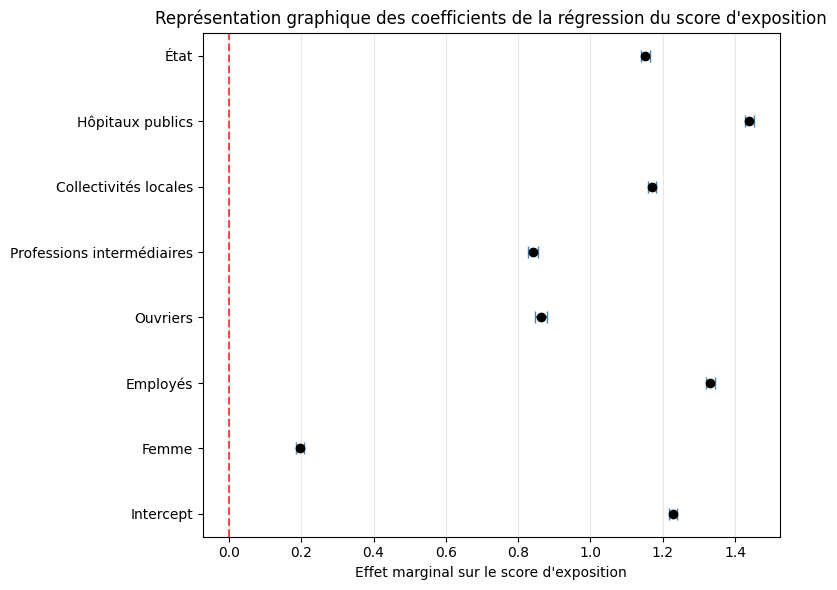

In [25]:
exposition.plot_regression_exposition(df_coef)

QUESTIONNER LA PERTINENCE D'UN MODELE DE REGRESSION LINEAIRE ET PAS LOGIT ORDONNE
inconvenient: certaines hypothèses du modèle linéaire: données continues non bornées => on peut prédire un score > 4 (à l'inverse des hommes cadres du privé, les femmes employées travaillant dans les hôpitaux publics ont un "score moyen" de 4.1978, toutes choses égales par ailleurs)
avantage (ou limites de l'inconvénient) : pas absurde car on compare des catégories seulement + de manière plus exploratoire que prédictive 

**Interprétation**

Intercept à 1.2 : un homme cadre du privé a un score moyen d’exposition de 1.2 sur 0–4
Par rapport à ce profil de référence, toutes choses égales par ailleurs, toutes les autres modalités augmentent significativement le score d'exposition au Covid. 

Les femmes ont un score moyen 0.197 point plus élevé que les hommes (référence), toutes choses égales par ailleurs (effet notable mais modéré). L'importance réduite de cet effet par rapport aux statistiques descriptives suggère que le lien fort existant entre sexe et exposition au Covid passe en partie par des différences de secteurs d'activité. 

Les professions moins qualifiées sont beaucoup plus exposées que les cadres supérieurs. Les employés ont un score moyen 1.33 point plus élevé que les cadres supérieurs. Les ouvriers et les professions intermédiaires ont un score moyen environ 0.85 point plus élevé que les cadres supérieurs. 

Enfin, le secteur public est beaucoup plus exposé, particulièrement les hôpitaux, qui ont une exposition moyenne 1.44 point plus élevée.

Le R^2 du modèle est de 0.40, ce qui signifie que 40% de la variance du score est expliquée par nos variable, ce qui est extrêmement fort en sciences sociales. Ces trois variables sont donc assez prédictives, même si rien ne garantit que les liens observés soient de nature causale.

[TRANSITION AVEC METHODE DES DOUBLES DIFFERENCES POUR TENTER DE METTRE A JOUR DES EFFETS CAUSAUX ?]

<a id="modelisation"></a>

# Covid long et réduction de l'offre de travail

Nous analysons à présent les effets des absences pour raisons de santé sur la participation à la population active à l’aide d’une étude d’événement.

## Doubles-différences

Afin d'évaluer l'impact de la pandémie sur les différents secteurs économiques, nous mobilisons une stratégie de différences-en-différences (DiD) en comparant les secteurs exposés au Covid-19 aux secteurs non exposés. Nous estimons dans un premier temps la spécification suivante :
$$
Y_{it}=\alpha + \tau_\text{DiD}(\mathbf{1}\{t\geq 2020\}\times\mathbf{1}\{\text{exposé}_i=1\}) + \mathbf{X}_{it} \Lambda_k + \gamma_i + \delta_t + \varepsilon_{it}
$$
où $Y_{it}$ représente le niveau d’activité (ou de participation) du secteur $i$ à la période $t$. La variable $\text{Exposé}_i$ est une indicatrice valant 1 si le secteur appartient au groupe traité, et $\text{Post}_t$ est une indicatrice valant 1 pour les années postérieures à 2020. Le vecteur $\mathbf{X}_{it}$ contient un ensemble de caractéristiques sectorielles variant dans le temps. Les termes $\gamma_i$ et $\delta_t$ désignent respectivement des effets fixes de secteur et de période, capturant les chocs temporels globaux et l'hétérogénéité sectorielle qui ne varie pas avec le temps. Dans ce cadre, le coefficient d'intérêt $\tau_{\text{DiD}}$ mesure l'effet moyen du traitement sur les traités (ATT), c'est-à-dire l'impact différentiel moyen de l'exposition au Covid-19 sur la variable de résultat des secteurs traités après 2020. Afin de garantir des inférences statistiques valides en présence d'une potentielle autocorrélation des erreurs au sein de chaque secteur d'activité, nous utilisons des erreurs standards robustes au niveau de chaque secteur.

Notre hypothèse d’identification suppose que, hormis l'épisode d’absence pour raisons de santé en 2020, il n’existerait aucune différence moyenne de taux de participation entre les secteurs, une fois que l'on a contrôlé pour leurs caractéristiques initiales $\mathbf{X}_{it}$ ainsi que pour le secteur et la période (effets fixes $\gamma_i$ et $\delta_t$). Dans ce cadre, le terme $\tau_\text{DiD}$ capture l'effet propre de l'exposition au Covid-19 sur la participation au marché du travail des salariés du secteur $i$ après 2020 en moyenne.

### Préparation des données

Dans notre stratégie d'identification, nous utilisons une approche au niveau de chaque groupe $i$ construit par l'intersection d'un secteur économique NAF et d'une catégorie socio-professionnelle.

In [35]:
# Données
df = eec_actifs

# Agrégation par CSP x NAF de la proportion d'individus ayant déclaré un arrêt maladie
## Création de la variable "groupe" en combinant CSE et NAFG038UN
df['groupe'] = df.groupby(['CSE', 'NAFG038UN']).ngroup()

## Création d'une indicatrice d'arrêt maladie
df['is_RABS_2'] = (df['RABS'] == '2')

Néanmoins, certaines de ces combinaisons n'ont pas beaucoup de sens.

In [37]:
## Montrer le tableau des effectifs inférieurs à 20 que l'on vire pour montrer que l'on sait manipuler et visualiser les données
check = df.groupby(['groupe']).filter(
    lambda x: (x.groupby('ANNEE').size() < 20).all()
    )

check.head()

,AAC,ACTEU,ANCCHOM,ANNEE,CHPUB,CSE,DISPPLC,EXTRIAN,NAFG038UN,OFFICC,...,PUB_label,CSE_label,CSER,CSER_label,NAF_label,score_CSE,score_NAFG038UN,score_exposition,groupe,is_RABS_2
455,,1,,2010,6,69,,137.428216,BZ,3,...,Secteur privé,Ouvriers agricoles,6.0,Ouvriers,Industries extractives,0.0,2.0,2.0,1227,False
911,1,1,,2010,6,67,1,112.677674,CD,1,...,Secteur privé,Ouvriers non qualifiés type industriel,6.0,Ouvriers,Cokéfaction et raffinage,2.0,0.0,2.0,1152,False
1133,2,1,,2010,6,55,,61.436752,UZ,3,...,État,Employés de commerce,5.0,Employés,Activités extra-territoriales,1.0,0.0,1.0,920,False
1859,,1,,2010,4,47,,105.197133,TZ,3,...,Secteur privé,Techniciens,4.0,Professions intermédiaires,Activités des ménages employeurs & production ...,0.0,0.0,0.0,712,False
2715,,1,,2010,3,34,,72.143038,,3,...,État,"Professeurs, professions scientifiques",3.0,Cadres et professions intellectuelles supérieures,Sans objet (inactifs occupés),1.0,NaN,1.0,337,False


On ne conserve donc que celles qui comptent plus de vingt actifs pour toutes les années de la période d'analyse, puis on agrége les données.

In [38]:
## Sélection des CSP x NAF avec au moins vingt actifs pour toutes les années de la période
df = df.groupby(['groupe']).filter(
    lambda x: (x.groupby('ANNEE').size() >= 20).all()
    )

## Agrégation par CSP x NAF
df = df.groupby(['groupe', 'ANNEE']).agg(
    sh_arret=('is_RABS_2', 'mean'),
    n_individus=('is_RABS_2', 'size'),
    cat_expose=('score_exposition', 'mean'),
).reset_index()

## Évaluation des groupes obtenus
n_groupes = len(df[['groupe']].drop_duplicates())
print(f"Nombre de combinaisons CSP x secteur : {n_groupes}")

## Affichage du résultat
df.head()

Nombre de combinaisons CSP x secteur : 419


,groupe,ANNEE,sh_arret,n_individus,cat_expose
0,0,2010,0.005376,186,2.0
1,0,2011,0.032787,61,2.0
2,0,2012,0.000000,45,2.0
3,1,2013,0.024658,365,3.0
4,1,2014,0.019364,723,3.0


Pour pouvoir identifier un effet, il est nécessaire de disposer de variabilité dans les données selon les groupes constitués et les années.

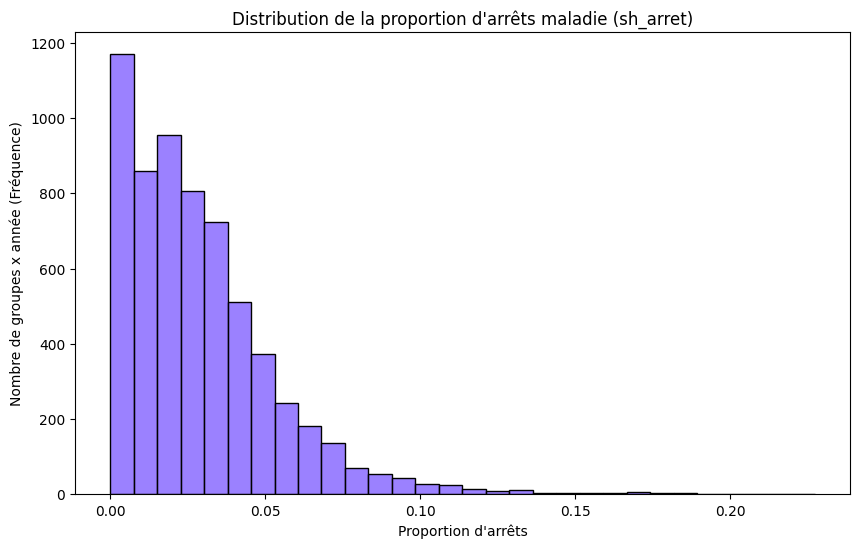

In [23]:
# On regarde la distribution des arrêts maladie
plt.figure(figsize=(10, 6))
sns.histplot(df['sh_arret'], bins=30, color='#7A57FF')
plt.title('Distribution de la proportion d\'arrêts maladie (sh_arret)')
plt.xlabel('Proportion d\'arrêts')
plt.ylabel('Nombre de groupes x année (Fréquence)')
plt.show()

On peut finalement préparer les données pour l'analyse

In [24]:
# Préparation des données pour l'analyse
## Construction des variables d'exposition 1{exposé == 1}
print(df['cat_expose'].unique())
df['expose_1'] = df['cat_expose'].isin([4]).astype(int)
df['expose_2'] = df['cat_expose'].isin([3, 4]).astype(int)
df['expose_3'] = df['cat_expose'].isin([2, 3, 4]).astype(int)

## Vérification
df.head()

[2. 3. 0. 1. 4.]


,groupe,ANNEE,sh_arret,n_individus,cat_expose,expose_1,expose_2,expose_3
0,0,2010,0.005376,186,2.0,0,0,1
1,0,2011,0.032787,61,2.0,0,0,1
2,0,2012,0.000000,45,2.0,0,0,1
3,1,2013,0.024658,365,3.0,0,1,1
4,1,2014,0.019364,723,3.0,0,1,1


In [25]:
# Données propres aux doubles-différences
## Création de la variable Post = 1{t >= 2020}
df['post'] = (df['ANNEE'] >= 2020).astype(int)

## Création du terme d'interaction 1{t >= 2020} x 1{exposé == 1} pour chaque définition du traitement
df['traitement_1'] = df['post'] * df['expose_1']
df['traitement_2'] = df['post'] * df['expose_2']
df['traitement_3'] = df['post'] * df['expose_3']

## Vérification
df.head(15)

,groupe,ANNEE,sh_arret,n_individus,cat_expose,expose_1,expose_2,expose_3,post,traitement_1,traitement_2,traitement_3
0,0,2010,0.005376,186,2.0,0,0,1,0,0,0,0
1,0,2011,0.032787,61,2.0,0,0,1,0,0,0,0
2,0,2012,0.000000,45,2.0,0,0,1,0,0,0,0
3,1,2013,0.024658,365,3.0,0,1,1,0,0,0,0
4,1,2014,0.019364,723,3.0,0,1,1,0,0,0,0
5,1,2015,0.019062,682,3.0,0,1,1,0,0,0,0
6,1,2016,0.021661,831,3.0,0,1,1,0,0,0,0
7,1,2017,0.016082,684,3.0,0,1,1,0,0,0,0
8,1,2018,0.020270,888,3.0,0,1,1,0,0,0,0
9,1,2019,0.012277,896,3.0,0,1,1,0,0,0,0


In [26]:
# Contrôle des données
df_reg = df.set_index(['groupe', 'ANNEE'])
print(f"Dimension des données : {df_reg.shape}")
print(f"Nombre de groupes uniques : {df_reg.index.get_level_values('groupe').nunique()}")
print(f"Nombre d'années uniques : {df_reg.index.get_level_values('ANNEE').nunique()}")

variance_y = df_reg['sh_arret'].var()
print(f"Variance de la variable sh_arret : {variance_y}")

n_nans = df_reg[['sh_arret', 'traitement_1']].isna().sum().sum()
print(f"Nombre de valeurs manquantes : {n_nans}")

Dimension des données : (6236, 10)
Nombre de groupes uniques : 419
Nombre d'années uniques : 15
Variance de la variable sh_arret : 0.0006143949741250797
Nombre de valeurs manquantes : 0


### Résultats

Une fois les données structurées convenablement, on estime notre spécification en double-différences.

In [27]:
# Estimation (DiD canonique)

## Définition de l'index pour les données de panel dans linearmodels
df_reg = df.set_index(['groupe', 'ANNEE'])

## Définition de la variable expliquée Y et de la variable dépendante X
Y = df_reg['sh_arret']
X = df_reg[['traitement_1']] 

# Configuration du modèle
modele = PanelOLS(
    Y,                      # Part d'arrêts maladie
    X,                      # Traitement
    entity_effects=True,    # Capte les différences de niveau entre les groupes (remplace 'expose')
    time_effects=True       # Capte l'évolution commune à tous les groupes (remplace 'post')
    )

# Estimation avec erreurs-types clusterisées (Robustes à l'autocorrélation intra-groupe)
resultat = modele.fit(cov_type='clustered', cluster_entity=True)

## Résultat
print(resultat.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sh_arret   R-squared:                        0.0049
Estimator:                   PanelOLS   R-squared (Between):              0.0266
No. Observations:                6236   R-squared (Within):               0.0158
Date:                Sat, Dec 20 2025   R-squared (Overall):              0.0237
Time:                        09:40:22   Log-likelihood                 1.579e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.632
Entities:                         419   P-value                           0.0000
Avg Obs:                       14.883   Distribution:                  F(1,5802)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             11.113
                            

On vérifie la robustesse de nos résultats à des définitions alternatives de l'exposition au Covid-19.

In [28]:
# Estimation pour des traitements alternatifs
liste_traitements = ['traitement_1', 'traitement_2', 'traitement_3']

for t in liste_traitements:
    print(f"\n{'='*40}")
    print(f"Estimation pour : {t}")
    print(f"{'='*40}")
    
    # On sélectionne la colonne de traitement spécifique
    X = df_reg[[t]]
    
    # On lance le modèle
    modele = PanelOLS(df_reg['sh_arret'], X, entity_effects=True, time_effects=True)
    resultat = modele.fit(cov_type='clustered', cluster_entity=True)
    
    # On affiche le coefficient estimé, la p-valeur et le R-carré
    print(resultat.params)
    print(f"P-value: {resultat.pvalues[0]:.3f}")
    print(f"R-squared (Within): {resultat.rsquared_within:.2f}")


Estimation pour : traitement_1
traitement_1    0.008529
Name: parameter, dtype: float64
P-value: 0.001
R-squared (Within): 0.02

Estimation pour : traitement_2
traitement_2    0.004613
Name: parameter, dtype: float64
P-value: 0.004
R-squared (Within): 0.02

Estimation pour : traitement_3
traitement_3    0.004489
Name: parameter, dtype: float64
P-value: 0.002
R-squared (Within): 0.03


/tmp/ipykernel_6874/4087343679.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value: {resultat.pvalues[0]:.3f}")
/tmp/ipykernel_6874/4087343679.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value: {resultat.pvalues[0]:.3f}")
/tmp/ipykernel_6874/4087343679.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value: {resultat.pvalues[0]:.3f}")


## Étude d'évènement

Pour explorer la dynamique temporelle des effets et tester la validité de notre hypothèse d'identification, nous généralisons l'approche précédente par une étude d'événement (event study) :
$$
Y_{it} = \alpha + \sum_{\substack{j \in T \\ j \neq -1}} \tau_j (\mathbf{1}\{t=j\} \times \mathbf{1}\{\text{exposé}_i=1\}) + \gamma_i + \delta_t + \varepsilon_{it}
$$
où $\mathbf{1}\{t=j\}$ est une indicatrice égale à 1 pour l'année relative $j\in T=\{-10,\cdots,+4\}$ de sorte que les coefficients $\tau_j$, pour $j \geq 0$, capturent les effets dynamiques de l'exposition au Covid-19 $j$ période(s) après 2020. Nous fixons l'année 2019 comme période de référence, de sorte que $\tau_{-1}=0$.

Cette spécification dynamique permet de vérifier l'hypothèse fondamentale de tendances parallèles. Celle-ci postule qu'en l'absence de pandémie, l'évolution de la variable $Y_{it}$ aurait été identique pour les secteurs exposés et non exposés. La nullité des coefficients $\tau_j$ pour $j \leq -2$ constitue un test de cette hypothèse.

Enfin, il convient de noter que notre cadre d'analyse repose sur une expérience naturelle où le traitement est administré de manière synchrone (en 2020). L'absence de décalage temporel dans l'adoption du traitement (staggered adoption) nous permet de nous affranchir des biais soulignés par Goodman-Bacon ([2021](https://www.google.com/search?client=safari&rls=en&q=Goodman-Bacon+A+(2021)+Difference-in-differences+with+variation+in+treatment+timing.+J+Econom+225(2)%3A254%E2%80%93277&ie=UTF-8&oe=UTF-8)). Par conséquent, l'estimateur par effets fixes bidirectionnels (TWFE) demeure convergent et ne nécessite pas le recours aux estimateurs robustes développés récemment pour les traitements échelonnés (e.g., Callaway et Sant’Anna, [2021](https://www.google.com/search?client=safari&rls=en&q=Callaway+B%2C+Sant%E2%80%99Anna+PH+(2021)+Difference-in-differences+with+multiple+time+periods.+J+Econom+225(2)%3A200%E2%80%93230&ie=UTF-8&oe=UTF-8) ; de Chaisemartin et d'Haultfœuille, [2022](https://www.nber.org/papers/w29873); Borusyak et al., [2024](https://academic.oup.com/restud/article/91/6/3253/7601390)).

### Préparation des données

On commence par préparer les données en construisant les indicatrices $\mathbf{1}\{t=j\}$ et $\mathbf{1}\{\text{exposé}_i=1\}$

In [29]:
# Données propres aux études d'évènement
## Création de la variable relative j "annee_relative" centrée sur 2020
df['annee_relative'] = (df['ANNEE'] - 2020).astype(int)

## Création des indicatrices 1{t == j}, sauf pour l'année relative de référence j == -1
df = (
    pd.get_dummies(df, columns=['annee_relative'], prefix='ttt')
    # On remplace le tiret '-' par 'm' dans les noms de colonnes
    .rename(columns=lambda x: x.replace('-', 'm'))
    # On supprime la colonne de référence (ttt_m1 correspond à j = -1)
    .drop(columns='ttt_m1', errors='ignore')
    # On définit l'index sur les identifiants de groupe et de temps
    .set_index(['groupe', 'ANNEE'])
)

## Création des termes d'interaction 1{t == j} x 1{exposé == 1}
var_traitement = 'expose_1'
dummies_annees_relatives = [c for c in df.columns if c.startswith('ttt')]
vars_interaction_event_study = []
for col in dummies_annees_relatives:
    # On multiplie l'indicatrice de temps 1{t == j} par le statut de traitement 1{exposé == 1}
    nom_colonne = f'{var_traitement}_{col}'
    df[nom_colonne] = df[var_traitement] * df[col]
    vars_interaction_event_study.append(nom_colonne)

### Résultats

On estime ensuite notre spécification dynamique.

In [30]:
# Estimation (Étude d'évènement)

## Définition de la variable expliquée Y et des variables d'interaction X
Y = df['sh_arret']
X = df[vars_interaction_event_study] # On met toutes les interactions (leads et lags)

## Configuration du modèle
modele = PanelOLS(
    Y,                      # Variable expliquée: part d'arrêts maladie Y_it
    X,                      # Variable explicatives: 1{t == j} x 1{exposé == 1}
    entity_effects=True,    # Effets-fixes groupes: gamma_i (capte les différences de niveau entre les groupes)
    time_effects=True       # Effets-fixes années: delta_t (capte l'évolution commune à tous les groupes)
)

## Estimation avec erreurs-types clusterisées (Robustes à l'autocorrélation intra-groupe)
resultat = modele.fit(cov_type='clustered', cluster_entity=True)

## Résultat
print(resultat.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               sh_arret   R-squared:                        0.0070
Estimator:                   PanelOLS   R-squared (Between):              0.0485
No. Observations:                6236   R-squared (Within):               0.0164
Date:                Sat, Dec 20 2025   R-squared (Overall):              0.0397
Time:                        09:40:22   Log-likelihood                  1.58e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.9166
Entities:                         419   P-value                           0.0002
Avg Obs:                       14.883   Distribution:                 F(14,5789)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             2.3074
                            

Pour rendre la lecture des résultats plus lisible, on les représente sous forme graphique. Chacun des points représente un $\tau_j$, et est associé à son intervalle de confiance à 95 %.

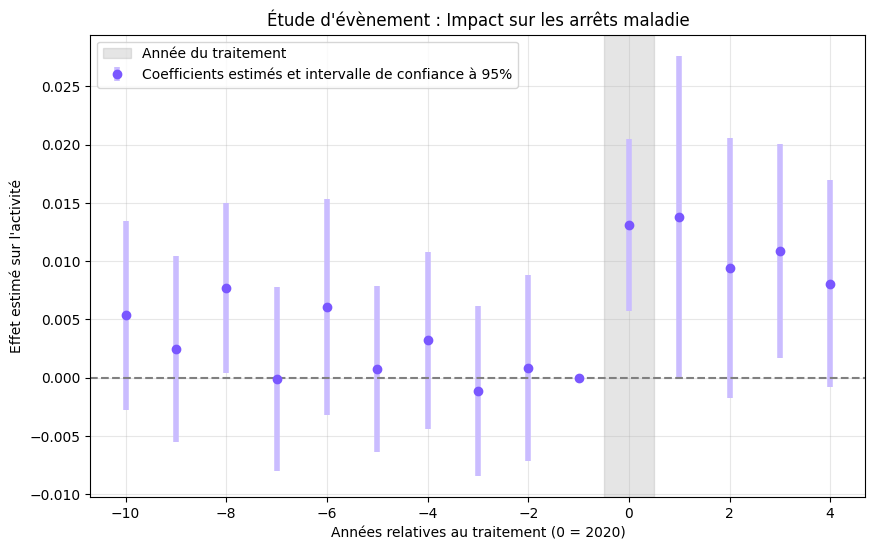

In [31]:
# Représentation graphique des résultats

## Récupération des coefficients estimés et des intervalles de confiance
est = resultat.params
ic = resultat.conf_int()

## Enregistrement dans un dataframe
df_plot = pd.DataFrame({
    'coef': est,
    'lower': ic.iloc[:, 0],
    'upper': ic.iloc[:, 1]
})

## Extraction des variables d'années relatives à partir du nom des variables
def extract_time(col_name):
    suffix = col_name.split('_')[-1] # Prend "m2" ou "0"
    if 'm' in suffix:
        return -int(suffix.replace('m', ''))
    return int(suffix)

df_plot['temps_relatif'] = [extract_time(idx) for idx in df_plot.index]

## Ajout manuel de l'année de référence (-1) où le coef est 0 par définition
row_ref = pd.DataFrame({'coef': [0], 'lower': [0], 'upper': [0], 'temps_relatif': [-1]})
df_plot = pd.concat([df_plot, row_ref]).sort_values('temps_relatif')

## Graphique
plt.figure(figsize=(10, 6))

plt.axvspan(-0.5, 0.5, color='grey', alpha=0.2, label='Année du traitement', zorder=0)

plt.errorbar(
    df_plot['temps_relatif'], 
    df_plot['coef'], 
    yerr=[df_plot['coef'] - df_plot['lower'], df_plot['upper'] - df_plot['coef']],
    fmt='o',
    color='#7A57FF', 
    ecolor='#CABCFF',
    elinewidth=4,
    capsize=0,
    label='Coefficients estimés et intervalle de confiance à 95%'
)

plt.axhline(0, linestyle='dashed', color='grey')

plt.title('Étude d\'évènement : Impact sur les arrêts maladie')
plt.xlabel('Années relatives au traitement (0 = 2020)')
plt.ylabel('Effet estimé sur l\'activité')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<a id="conclusion"></a>

# Conclusion

# Bibliographie complémentaire

- Jorge A Morales-Camino, SPL07 LONG COVID IMPACT ON WORKERS AND ITS MONITORING IN OCCUPATIONAL HEALTH, *Occupational Medicine*, Volume 74, Issue Supplement_1, July 2024, Page 0, https://doi.org/10.1093/occmed/kqae023.0018 (https://academic.oup.com/occmed/article/74/Supplement_1/0/7706674)
- von Wachter, Till. 2021. "Long-Term Employment Effects from Job Losses during the COVID-19 Crisis? A Comparison to the Great Recession and Its Slow Recovery." *AEA Papers and Proceedings* 111: 481–85.
- Gottlieb M, Chen J, Yu H, et al. Work Impairment and Financial Outcomes Among Adults With vs Without Long COVID. JAMA Netw Open. 2025;8(8):e2526310. doi:10.1001/jamanetworkopen.2025.26310 montre que "financial and work outcomes were worse in participants with current LC up to 3 years after initial infection. COVID-19 vaccination was associated with better work and financial outcomes."
- https://www.sciencedirect.com/science/article/pii/S2772707624001644 montre que "Long COVID reduces work productivity" au Japon
